In [22]:
#import python libraries
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

# Read the data

In [23]:
data_set = pd.read_csv('Google_Stock_Price.csv',thousands=',')
data_set.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800


In [24]:
data_set.shape

(1258, 6)

In [25]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


# Handling missing values

In [26]:
# check if there are null values
data_set.isnull().any()

Date      False
Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

<AxesSubplot:xlabel='Date'>

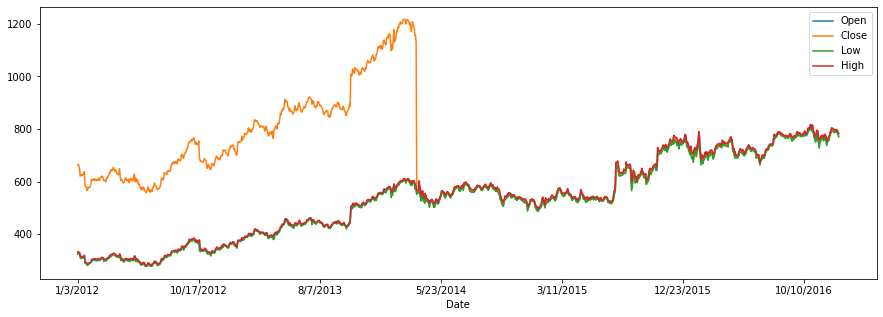

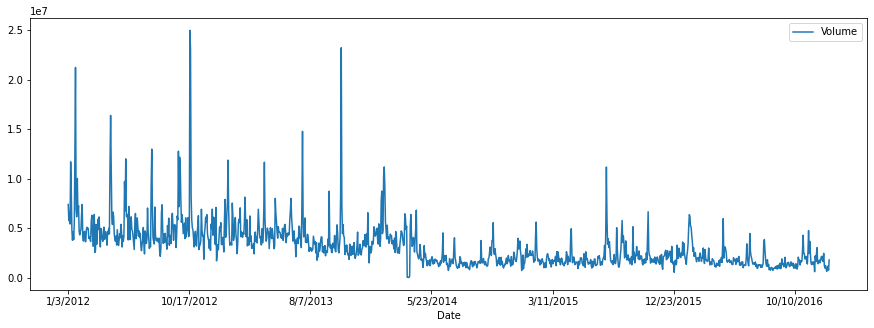

In [27]:
data_set.plot(x="Date", y=["Open","Close","Low","High"], kind="line",figsize=(15,5))
data_set.plot(x="Date", y=["Volume"], kind="line",figsize=(15,5))

In [28]:
# remove the 'close' column
data_set=data_set.drop(['Close'],axis=1)

<AxesSubplot:>

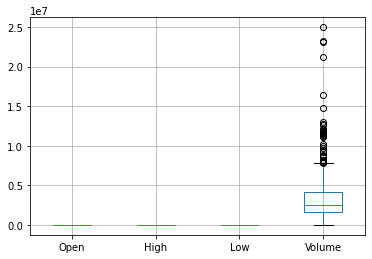

In [29]:
data_set.boxplot()

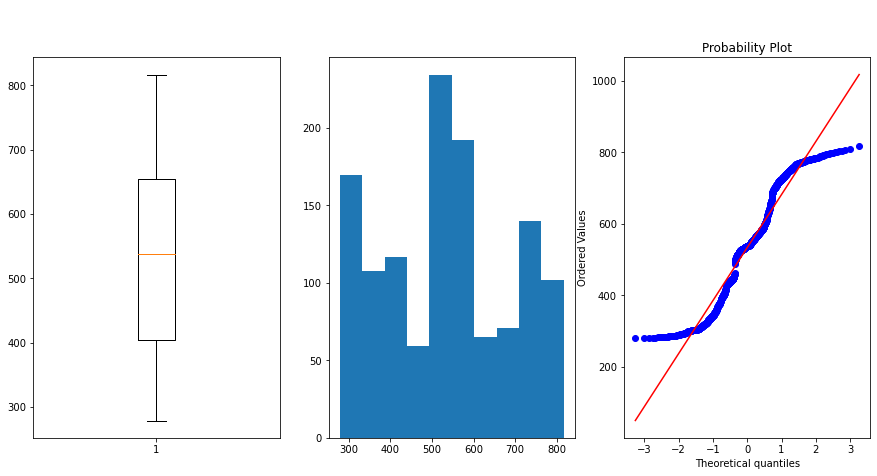

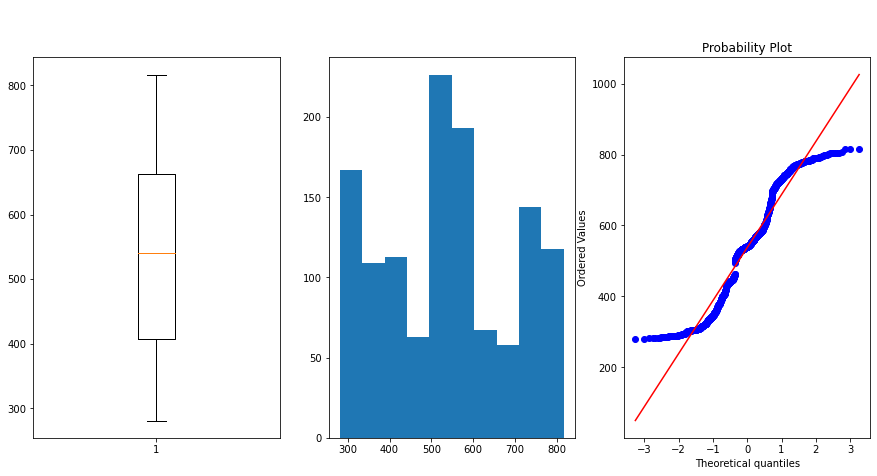

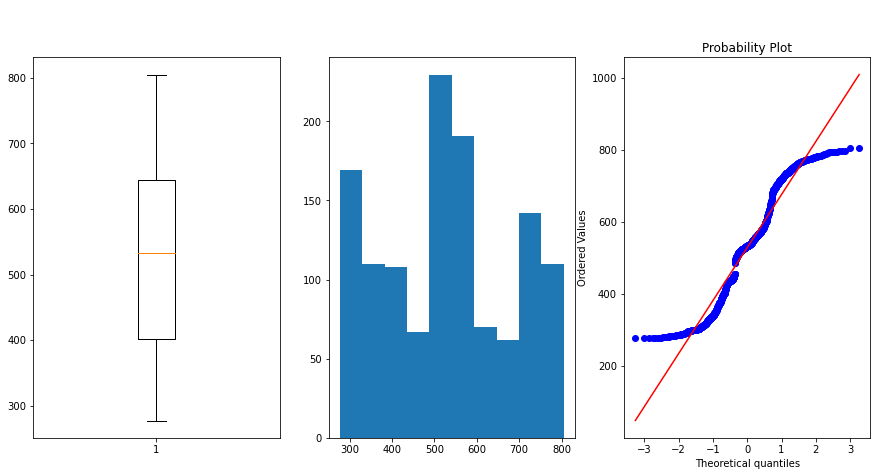

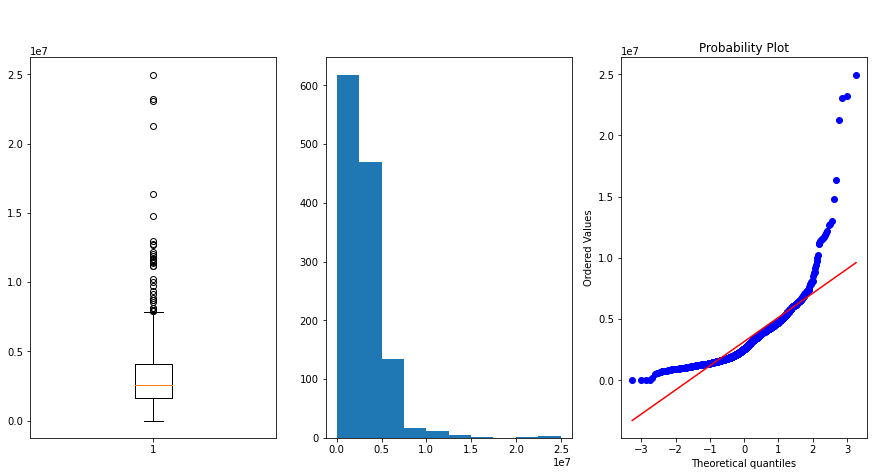

In [30]:
cols = data_set.select_dtypes(include=np.number).columns

for col in cols:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
    fig.suptitle(col.capitalize(), fontsize=20, color='White')
    axes[0].boxplot(data_set[col])
    axes[1].hist(data_set[col])
    stats.probplot(data_set[col], dist="norm", plot=axes[2])
    plt.show()

# Data transformation

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>],
       [<AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Volume'}>]], dtype=object)

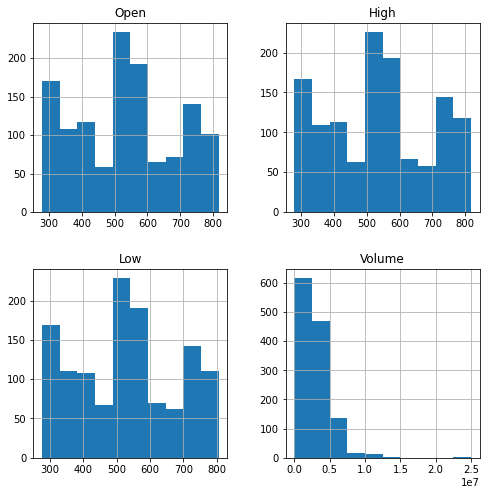

In [31]:
data_set.hist(figsize = (8,8))

In [32]:
numerical_df = data_set.drop('Date', 1)
numerical_df.head()

,Open,High,Low,Volume
0,325.25,332.83,324.97,7380500
1,331.27,333.87,329.08,5749400
2,329.83,330.75,326.89,6590300
3,328.34,328.77,323.68,5405900
4,322.04,322.29,309.46,11688800


# Scaling and standardization

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>],
       [<AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Volume'}>]], dtype=object)

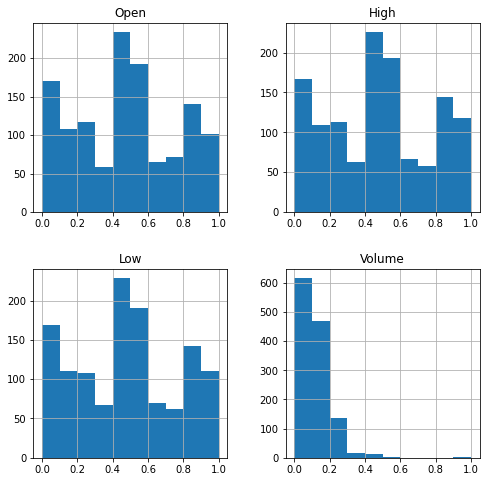

In [33]:
scaler = MinMaxScaler()
new_df = pd.DataFrame(scaler.fit_transform(numerical_df) ,columns = numerical_df.columns)
new_df.hist(figsize = (8,8))

,Open,High,Low,Volume
Open,1.000000,0.999692,0.999498,-0.530506
High,0.999692,1.000000,0.999480,-0.526936
Low,0.999498,0.999480,1.000000,-0.538273
Volume,-0.530506,-0.526936,-0.538273,1.000000


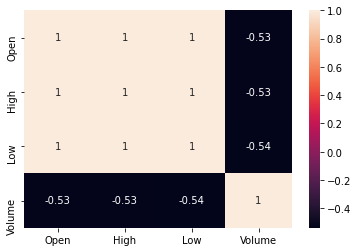

In [34]:
sns.heatmap(new_df.corr(), annot=True)
new_df.corr()

In [35]:
# enough getting 1 other and volume field
new_df=new_df.drop(['Open','Low'],axis=1)
new_df.shape

(1258, 2)

# RNN

In [36]:
# split a univariate sequence into samples
def split_seq_multi(sequence, n_past, n_future):
    
    x, y = [], [] 
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window
        past   = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)
    
    return np.array(x), np.array(y)

In [37]:
# specify the window size
n_steps = 73
# split into samples
X, y = split_seq_multi(new_df.to_numpy(), n_steps,1)

In [38]:
X.shape

(1185, 73, 2)

In [39]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=50)

print("X_train shape:",X_train.shape,"    y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape,"     y_test shape:", y_test.shape)

X_train shape: (948, 73, 2)     y_train shape: (948, 1)
X_test shape: (237, 73, 2)      y_test shape: (237, 1)


In [40]:
# define RNN model
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(n_steps,2)))  
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               41200     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 50,361
Trainable params: 50,361
Non-trainable params: 0
_________________________________________________________________


In [42]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_test, y_test)) 

Epoch 1/100
30/30 - 4s - loss: 0.0060 - mae: 0.0468 - val_loss: 0.0029 - val_mae: 0.0370
Epoch 2/100
30/30 - 1s - loss: 0.0048 - mae: 0.0390 - val_loss: 0.0028 - val_mae: 0.0345
Epoch 3/100
30/30 - 1s - loss: 0.0045 - mae: 0.0371 - val_loss: 0.0028 - val_mae: 0.0354
Epoch 4/100
30/30 - 1s - loss: 0.0046 - mae: 0.0383 - val_loss: 0.0031 - val_mae: 0.0377
Epoch 5/100
30/30 - 1s - loss: 0.0046 - mae: 0.0390 - val_loss: 0.0029 - val_mae: 0.0333
Epoch 6/100
30/30 - 1s - loss: 0.0045 - mae: 0.0371 - val_loss: 0.0025 - val_mae: 0.0347
Epoch 7/100
30/30 - 1s - loss: 0.0044 - mae: 0.0365 - val_loss: 0.0024 - val_mae: 0.0338
Epoch 8/100
30/30 - 1s - loss: 0.0044 - mae: 0.0377 - val_loss: 0.0033 - val_mae: 0.0383
Epoch 9/100
30/30 - 1s - loss: 0.0044 - mae: 0.0377 - val_loss: 0.0022 - val_mae: 0.0319
Epoch 10/100
30/30 - 1s - loss: 0.0041 - mae: 0.0351 - val_loss: 0.0021 - val_mae: 0.0292
Epoch 11/100
30/30 - 1s - loss: 0.0042 - mae: 0.0354 - val_loss: 0.0021 - val_mae: 0.0282
Epoch 12/100
30/30 

30/30 - 1s - loss: 0.0029 - mae: 0.0311 - val_loss: 0.0023 - val_mae: 0.0305
Epoch 93/100
30/30 - 1s - loss: 0.0029 - mae: 0.0314 - val_loss: 0.0022 - val_mae: 0.0311
Epoch 94/100
30/30 - 1s - loss: 0.0029 - mae: 0.0308 - val_loss: 0.0022 - val_mae: 0.0313
Epoch 95/100
30/30 - 1s - loss: 0.0033 - mae: 0.0325 - val_loss: 0.0023 - val_mae: 0.0313
Epoch 96/100
30/30 - 1s - loss: 0.0029 - mae: 0.0312 - val_loss: 0.0021 - val_mae: 0.0286
Epoch 97/100
30/30 - 1s - loss: 0.0028 - mae: 0.0311 - val_loss: 0.0021 - val_mae: 0.0299
Epoch 98/100
30/30 - 1s - loss: 0.0030 - mae: 0.0323 - val_loss: 0.0021 - val_mae: 0.0287
Epoch 99/100
30/30 - 1s - loss: 0.0029 - mae: 0.0317 - val_loss: 0.0022 - val_mae: 0.0307
Epoch 100/100
30/30 - 1s - loss: 0.0029 - mae: 0.0315 - val_loss: 0.0019 - val_mae: 0.0275


In [43]:
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae))

MSE: 0.002, RMSE: 0.044, MAE: 0.027


In [44]:
# predicting y_test values
print(X_test.shape)
y_pred = model.predict(X_test)

(237, 73, 2)


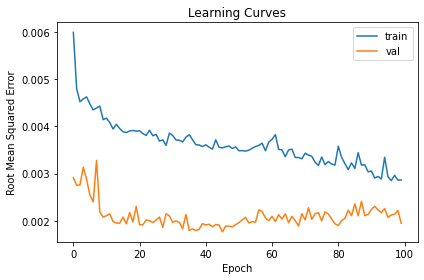

In [45]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.tight_layout()
plt.show()

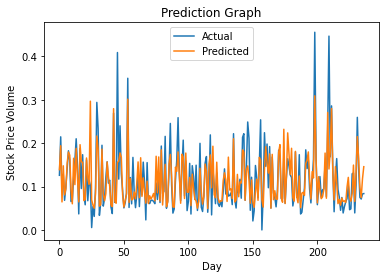

In [46]:
plt.plot(y_test)
plt.plot(y_pred)
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Prediction Graph')
plt.legend(['Actual','Predicted'],loc = 'upper center')
plt.show()

In [47]:
y_pred = model.predict(X_test)
print('R2 Score: ', r2_score(y_test, y_pred))

R2 Score:  0.6114150746684408
